# Проект "Компьютер говорит нет". Credit Scoring.
Работу выполнил: Перебатов Михаил (DST-48).

### Задача
Построить скоринговую модель для будующих клиентов банка, которая бы предсказывала вероятность невозрвата кредита.

**Этапы решения:**

Подготовка набора данных для обучения модели  
Попрактика работы с pandas на реальных данных  
Попрактика в предобработке различных данных, в частности с пропущенными данными (Nan) и с различными видами кодирования признаков  
Практика в Feature Engineering  
Практика в построении модели, в определении оптимальных гиперпарамтров для нее  
Практика в работе с несбалансированной выборкой и методами работы с ней  


### Описание признаков:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# Импорт библиотек и данных для работы

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve 

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV 
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")


**Дополнительные функции**

In [2]:
# функция подсчета количества выбросов
def count_outlier(df_in, col_name):
    q25 = df_in[col_name].quantile(0.25)
    q75 = df_in[col_name].quantile(0.75)
    iqr = q75 - q25 
    fence_low  = q25 - 1.5*iqr
    fence_high = q75 + 1.5*iqr
    count_outlier = df_in[df_in[col_name] < fence_low].shape[0]+\
                    df_in[df_in[col_name] > fence_high].shape[0]                  
    print(f'Всего выбросов в {col_name} - {count_outlier}')


In [3]:
# функциии визуализации графика ROC_AUC, confusion matrix и основных метрик
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_cmatrix(model, X_test, y_test, title=None):
    disp = plot_confusion_matrix(model, X_test, y_test)
    disp.ax_.set_ylabel('Истинный класс')
    disp.ax_.set_xlabel('Предсказанный класс')
    if title:
        disp.ax_.set_title(title)
        
def print_metrics(y_test, y_pred):        
    print('accuracy_score:',round(accuracy_score(y_test, y_pred),4))
    print('precision_score:',round(precision_score(y_test, y_pred),4))
    print('recall_score:',round(recall_score(y_test, y_pred),4))
    print('f1_score:',round(f1_score(y_test, y_pred),4))
       

**Исходные данные**

In [4]:
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path + 'train.csv', parse_dates=['app_date'])
test= pd.read_csv(path + 'test.csv', parse_dates=['app_date'])
sample = pd.read_csv(path +'sample_submission.csv')

print(f'Размер обучающей выборки {train.shape}\n\
Размер тестовой выбоки {test.shape}')
train.sample(3)

Размер обучающей выборки (73799, 19)
Размер тестовой выбоки (36349, 18)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
55017       2803 2014-01-08       UGR   M   29   N        N                0   
51956      82608 2014-03-31       GRD   M   28   N        N                0   
20758      22637 2014-01-29       SCH   M   35   Y        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
55017          0  -1.737075                1             50             2   
51956          1  -1.463811                3             50             1   
20758          0  -2.110925                1             60             1   

       work_address  income  sna  first_time foreign_passport  default  
55017             3   20000    3           3                N        1  
51956             2   30000    2           3                N        0  
20758             2   45000    2           2                N        1

# 1. Анализ данных

In [5]:
# Посмотрим автоматизированный первичный анализ данных для тренировочной выборки
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
for col in ["age", "decline_app_cnt", "score_bki","bki_request_cnt", "income"]:
    count_outlier(train, col)

Всего выбросов в age - 0
Всего выбросов в decline_app_cnt - 12585
Всего выбросов в score_bki - 351
Всего выбросов в bki_request_cnt - 1755
Всего выбросов в income - 4695


**Выводы из отчета:** 

    1) Наблюдаем логнормальное распределение  со смещением вправо для таких признаков как: age, decline_app_cnt, bki_request_cnt, income.   Прологарифмируем значения этих полей. 
    2) Сильной взаимосвязи между независимыми признаками нет. Наибольшая взаимосвязь между признаками (home_address - work_address), (sna - first_time), (car - car_type).
    3) Выявлено 307 пропусков в поле education (< 0.1%) с случайным распределением. Заполним эти пропуски модой.
    4) В числовых признаках влияющих на целевую переменную присутствуют значительное число выбросов.
    5) Признак client_id не несет полезной информации, на целевую переменную не влияет. Удалим его
    6) Признак app_date говорит нам что пополнение данных происходило в течении 4 месяцев в 2014 году, выглядит бесполезным. 

In [7]:
# Объединим тестовую и обучающую выборки, для совместной обработки признаков
train['sample'] = 1   # помечаем где у нас трейн
test['sample'] = 0    # помечаем где у нас тест
test['default'] = -1  # добавим в тесте колонку с отсутствующими значениями
df_bank = pd.concat([train, test]).reset_index(drop=True)

In [8]:
# Разобьем признаки на списки:
# числовые
num_cols = ["age", "decline_app_cnt", "bki_request_cnt",
            "income", "score_bki"]

# бинарные, количество уникальных значений которых равно двум
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = ["education", "region_rating","home_address", "work_address", "sna", "first_time"]
# client_id, app_day, default и sample исключены из списков.


# 2. Предобработка

In [9]:
# избавимся от пропущенных значений в поле education,учтем данные в столбце good_work, имеющим связь  с образованием.
# Запомним что внесли изменения в тестовую выборку(test) с учетом всей выборки.
df_bank['education'] = df_bank.groupby('good_work')\
['education'].apply(lambda x: x.fillna(x.mode().iloc[0]))

<AxesSubplot:xlabel='education', ylabel='income'>

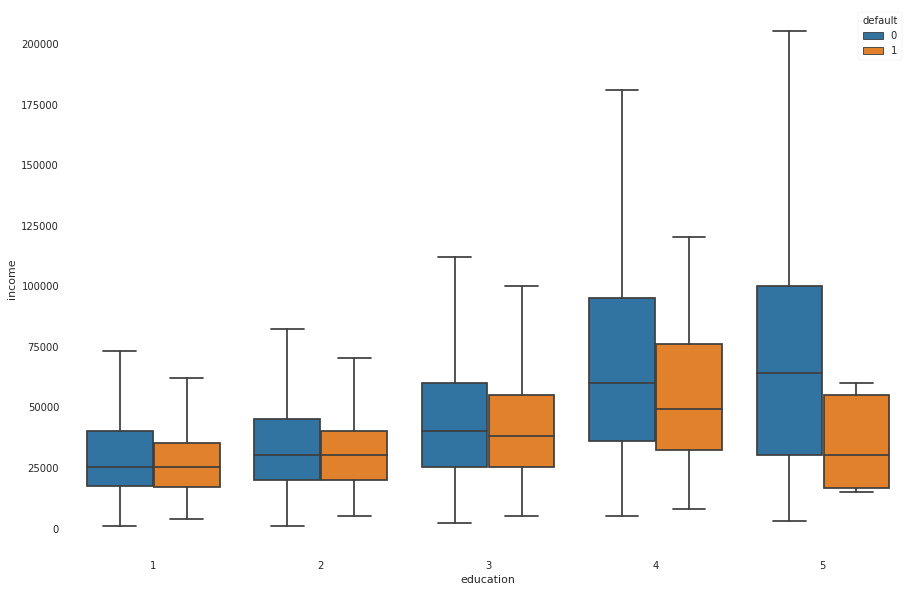

In [10]:
# Из категориальных только образование требует перекодирования в числовой формат. 
# Так как образование напрямую зависит от уровня доходов и ответственности граждан(исключая несколько задолжавших ученых) 
# переведем его в числа в соответствии со словарем. 
education_dict ={'SCH':1, 'UGR':2, 'GRD':3,'PGR':4,'ACD':5}
df_bank['education'] = df_bank['education'].map(education_dict)
plt.figure(figsize=(15, 10))
sns.boxplot(x="education", y="income", hue = 'default', 
            data=df_bank.query('sample == 1'), showfliers=False)

In [11]:
#Переведем бинарные признаки в числа.
dict_bin = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df_bank[col] = label_encoder.fit_transform(df_bank[col])
    dict_bin[col] = dict(enumerate(label_encoder.classes_))
pd.DataFrame(dict_bin) #выведем словарь по признакам

sex car car_type  good_work foreign_passport
0   F   N        N          0                N
1   M   Y        Y          1                Y

In [12]:
#Посмотрим есть ли польза от app_data, и как этот признак связан с индификатором клиента
df_bank.app_date = pd.to_numeric(df_bank.app_date)
print('Коэф. корр. -',df_bank.app_date.corr(df_bank.client_id))

Коэф. корр. - 0.9995812203158332


In [13]:
# Oбъединим поля car_type и car, так как они повторяют друг друга 
#В поле car_type теперь будут признаки: 0-отсутствие машины, 1 -отечественная, 2- иномарка, 
df_bank['car_type'] += 1
df_bank['car_type'][df_bank['car'] == 0] = 0
bin_cols.remove('car')
cat_cols.append('car_type')

In [14]:
# Удалим поля app_date и client_id, car как лишние.
df_bank.drop(['app_date','client_id', 'car'],inplace = True, axis = 1)

Всего выбросов в age - 0
Всего выбросов в income - 2609
Всего выбросов в decline_app_cnt - 18677
Всего выбросов в bki_request_cnt - 15


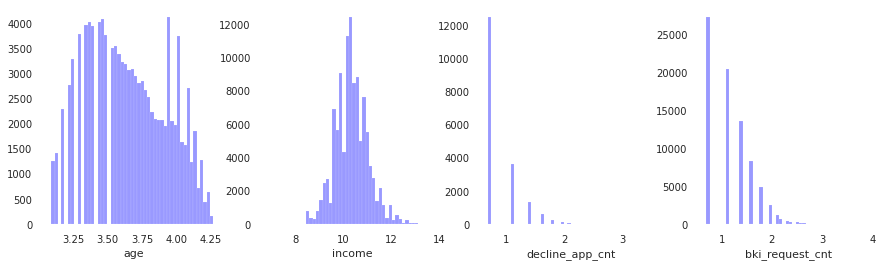

In [15]:
# Проведем логарифмирование числовых признаков с логнормальным распределением.
# логарифмирование признаков "decline_app_cnt", "bki_request_cnt"  не приводит к нормальному распределению 
fig, axes = plt.subplots(1, 4, figsize=(15,4))
for i,col in enumerate(["age", "income", "decline_app_cnt", "bki_request_cnt"]):
    df_bank[col] = np.log(df_bank[col] + 1)
    sns.distplot(df_bank[col][df_bank[col] > 0], 
                 ax=axes.flat[i],
                 kde = False, 
                 rug=False,color="b")
    count_outlier(df_bank, col) # посмотрим выбросы после логарифмирования


**Посмотрим какие признаки наиболее значимы для прогноза дефолта**

<AxesSubplot:title={'center':'Значимость числовых непрерывных переменных по ANOVA F test'}>

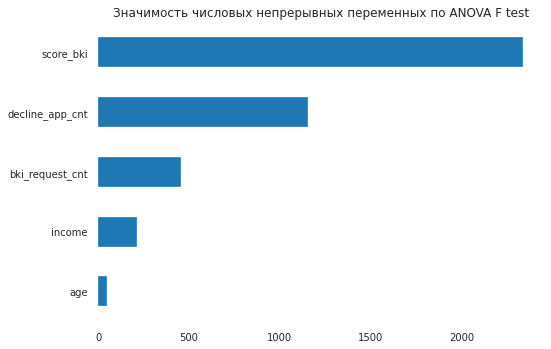

In [16]:
# используем функцию  однофакторный дисперсионный анализ (ANOVA) для оценки числовых признаков]:
df_plot = df_bank.query('sample == 1')
imp_num = pd.Series(f_classif(df_plot[num_cols], df_plot['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых непрерывных переменных по ANOVA F test')

<AxesSubplot:title={'center':'Значимость бин. и категор. переменных по Mutual information test'}>

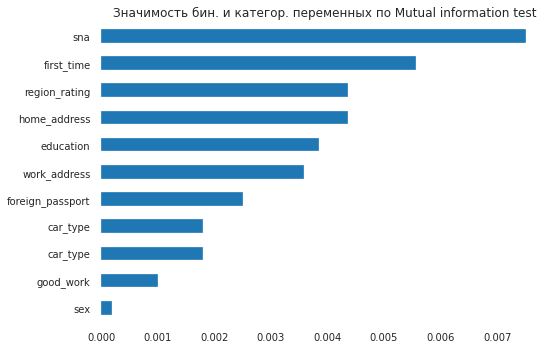

In [17]:
# используем функцию  Mutual information теста для оценки:
cat_and_bin_cols = bin_cols + cat_cols
imp_cat = pd.Series(mutual_info_classif(df_plot[cat_and_bin_cols], 
                    df_plot['default'], discrete_features =True), index = cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test')

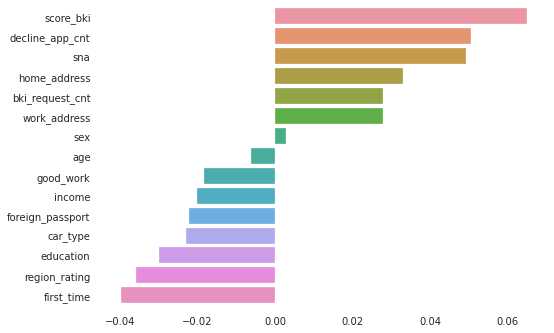

In [18]:
# Посмотрим наибольшие корреляционные связи с  переменной дефолт
all_cols = set(df_bank.columns) - set(['default','sample'])
correlations = df_bank[all_cols]\
        .corrwith(df_bank['default']).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)

<AxesSubplot:>

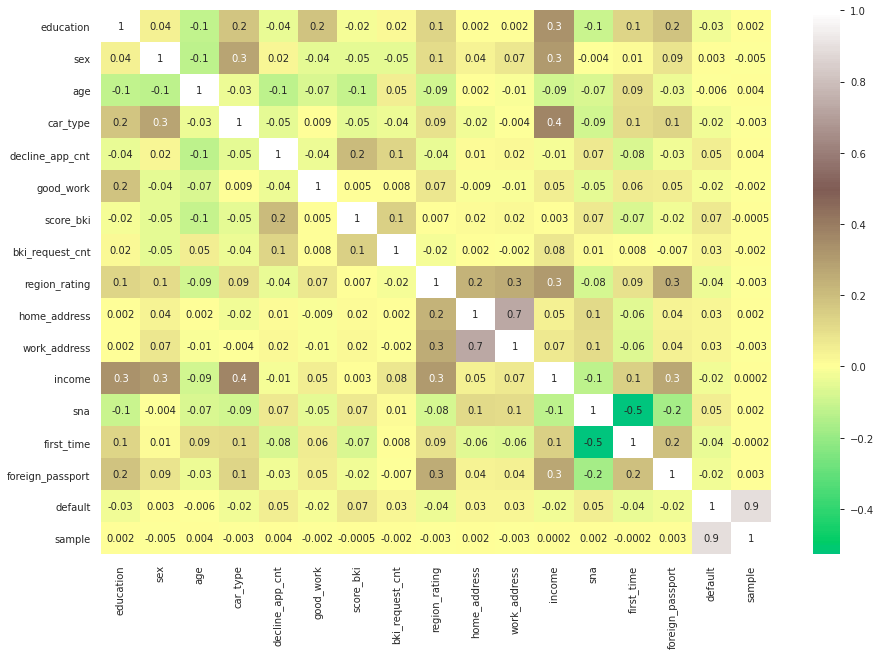

In [19]:
#посмотрим корреляционные связи между признаками
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_bank.corr(), cmap = 'terrain', annot=True, fmt='.1g', center=0, ax=ax)

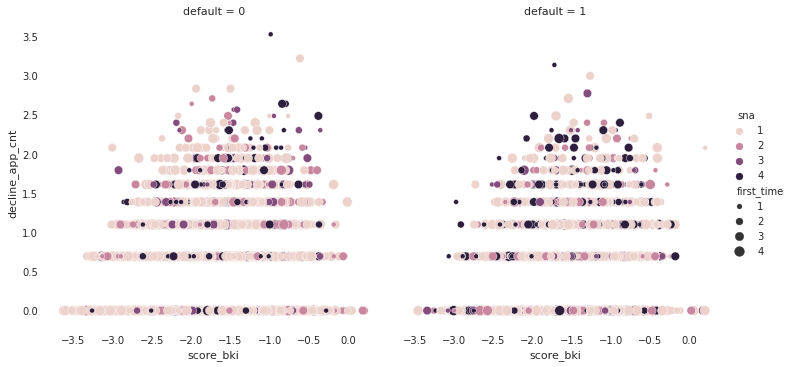

In [20]:
# Попробуем разглядеть связи на графике
sns.relplot(x="score_bki", 
            y="decline_app_cnt", 
            hue="sna", 
            col = 'default',  
            size="first_time",
            data=df_plot)

<AxesSubplot:xlabel='home_address', ylabel='work_address'>

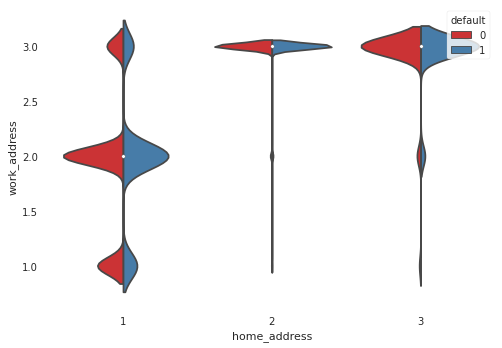

In [21]:
# Посмотрев зависимость адреса дома и работы можно сделать вывод, что отдающие кредит и не отдающие его
# работают в центре(3), а живут за городом(1), все очевидно.
sns.violinplot( data=df_plot, x="home_address", y = "work_address", 
               hue='default', split=True, palette='Set1')


In [22]:
# Попробуем объединить рабочий и домашний адреса методом декомпозиции.
# Выберем из датасета нужные колонки:
data = df_bank[['work_address', 'home_address']].values

# Создадим Scaler instance:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Из двух столбцов сделаем один путем усечения ненужной информации.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df_bank['address'] = pca_data

# Уберем лишние признаки:
df_bank = df_bank.drop(['home_address','work_address'],axis=1)

# Приведем в порядок списки:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

## Выводы:
Дефолтные клиенты практически ничем не отличаются от обычных заемщиков.   
Высокие доходы хорошо коррелируют с признаками богатства и обычно это образованные мужчины с иномаркой и загранпаспортом,живущие в хорошем районе.   
Важно предсказать дефолт среди богатых клиентов, ведь они приносят больше убытков.
Удивительно но доходы клиента оказывают наименьшее влияние на вероятность дефолта.  
Лучшие признаки для предсказания  дефолта это: score_bki, decline_app_cnt, sna, first_time, region_rating.  

## 2.2 Future Engeneering

In [23]:
# реализуем метод OneHotLabels 
cat_cols = ["address", "sna", "first_time"]
df = pd.get_dummies(df_bank, prefix=cat_cols, columns=cat_cols) 
df.shape

(110148, 30)

In [24]:
# добавим показатель богатства
df_bank_1 = df_bank[['education', 'sex', 'car_type', 'region_rating', 'foreign_passport']] 
df_bank_1 += 1
df_bank['rich'] = df_bank_1.prod(axis = 1)
num_cols.append('rich')

# 3. Построение модели

## Модель 1 

In [25]:
RANDOM_SEED = 42
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

# еще раз делим тренировочные данные на тестовую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [26]:
# стандартизацию проводим отдельно для валидационной и тестовых выборок,
Scaler = RobustScaler()
X_train_sc = Scaler.fit_transform(X_train)
X_test_sc = Scaler.transform(X_test)
test_final = Scaler.transform(test_data)

In [27]:
# первая модель 
model_bank = LogisticRegression(random_state=RANDOM_SEED)
model_bank.fit(X_train_sc, y_train)

y_pred_prob = model_bank.predict_proba(X_test_sc)[:,1]
y_pred = model_bank.predict(X_test_sc)

**Оценка качества модели**

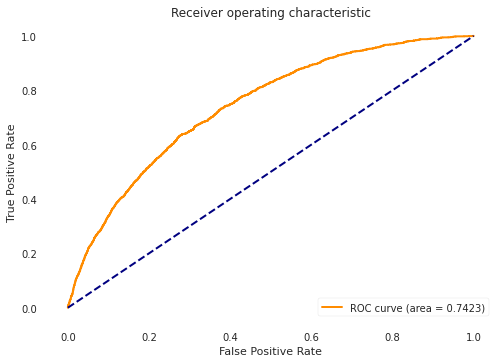

accuracy_score: 0.8753
precision_score: 0.43
recall_score: 0.0235
f1_score: 0.0446


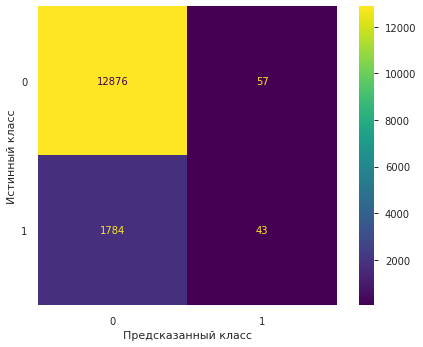

In [28]:
# посмотрим метрики 
plot_roc_curve(y_test, y_pred_prob)
plot_cmatrix(model_bank,X_test_sc,y_test)
print_metrics(y_test, y_pred)


## Выводы:
Модель с хорошим показателем ROC-AUС = 0.742, не в состоянии предсказать дефолтных клиентов (угадывает  43 из 1817).   
Об этом также свидетельствует метрика полноты recall = 0.0235, такая модель будет выдавать кредиты людям которые  не смогут их вернуть.

## Модель 2. Oversampling

In [29]:
#Попробуем убрать несбалансированность дефолтных клиентов и обычных. 
#Попробуем применить в этом случае oversampling, чтобы сгладить эту разницу.

smote = SMOTE(random_state=RANDOM_SEED)
X_sm, y_sm = smote.fit_resample(X_train_sc, y_train)

In [30]:
# вторая модель 
model_bank_2 = LogisticRegression(random_state=RANDOM_SEED)
model_bank_2.fit(X_sm, y_sm)

y_pred_prob = model_bank_2.predict_proba(X_test_sc)[:,1]
y_pred = model_bank_2.predict(X_test_sc)

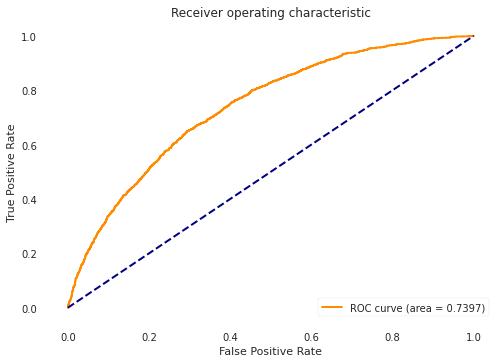

accuracy_score: 0.6667
precision_score: 0.2231
recall_score: 0.682
f1_score: 0.3362


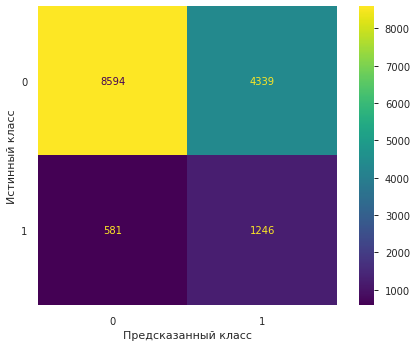

In [31]:
# посмотрим метрики 
plot_roc_curve(y_test, y_pred_prob)
plot_cmatrix(model_bank_2,X_test_sc,y_test)
print_metrics(y_test, y_pred)

## Выводы:
Модель стала выглядеть лучше, хотя  показатель ROC-AUС снизился до  0.739. Данная модель лучше предскажет дефолтных клиентов (угадывает  1246 из 1817), но многих платежеспособных клиентов банк отвергнет и ничего не заработает (4338).     
Метрика полноты recall = 0.68, такая модель будет выдавать кредиты людям большинство из которых  смогут их вернуть.
Примем эту модель на данном датасете, так как здесь есть золотая середина между отказами и недополученной выгодой.

# 4. Поиск оптимальных параметров модели (GridsearchCV)

In [32]:
model_bank_3 = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model_bank_3, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_bank_3 = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model_bank_3.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [33]:
model_bank_3.fit(X_sm, y_sm)

y_pred_prob = model_bank_3.predict_proba(X_test_sc)[:,1]
y_pred = model_bank_3.predict(X_test_sc)

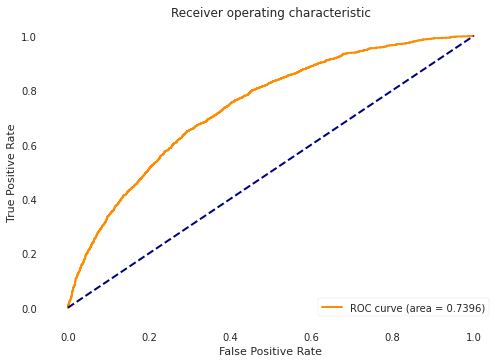

accuracy_score: 0.6666
precision_score: 0.223
recall_score: 0.6814
f1_score: 0.336


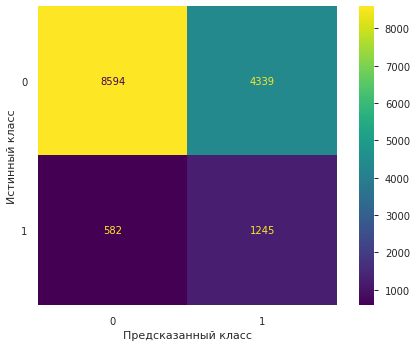

In [34]:
# посмотрим метрики 
plot_roc_curve(y_test, y_pred_prob)
plot_cmatrix(model_bank_3,X_test_sc,y_test)
print_metrics(y_test, y_pred)

## Итог:
В результате работы над данными:

* был произведен разведывательный анализ данных
* созданы новые признаки
* отбраны признаки для модели по значимости
* произведена балансировка классов с помощью undersampling
* подобраны оптимальные гиперпараметры для модели, не улучшили оценку
* проведена проверка модели на переобучение - результат отрицательный
В финальной версии модели score - **0.739**

# 5.Submission

In [35]:
test_data = test_final
y_pred = model_bank_2.predict_proba(test_data)
results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})

In [36]:
results_df

client_id   default
0          74835  0.242413
1          17527  0.753484
2          75683  0.304849
3          26883  0.417032
4          28862  0.129453
...          ...       ...
36344      83775  0.799406
36345     106254  0.127435
36346      81852  0.810523
36347       1971  0.607067
36348      69044  0.761228

[36349 rows x 2 columns]

In [37]:
results_df.to_csv('submission2.csv', index=False)